In [1]:
## uses allbanks file for all dates
## this uses modeldata (prior to 1/1/2010), but exhibits should be based on forecasts >1/1/2009
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
import random as rd

import sys
import os
os.chdir('C:/DGU/DU/FDIC')

In [2]:
md = pd.read_csv('allbanks_f2468_roe0mm2_20091231.csv',index_col=0)
md['AsOf'] = pd.to_datetime(md['AsOf'])
md['FailDate'] = pd.to_datetime(md['FailDate'])

In [3]:
len(md)

395257

In [4]:
md['xf4_2'] = md.apply(lambda x: -np.log((1/x['f4_2'])-1),axis=1) # logit function (converts pd to z-score)
md.tail(2)

IDRSSD       AsOf                            Name State   eTotAst  \
405035  4569167 2014-12-31             NEW TRADITIONS BANK    FL  505699.0   
405039  4589857 2014-09-30  INVESCO NATIONAL TRUST COMPANY    GA   39151.0   

         rcTotLn  qnTotLn        rNIM     rPPNR       rROA    ...      f8  \
405035  0.048897      0.0    3.429863  1.871445   0.938726    ...       0   
405039  0.000000      0.0  188.235294  3.837989  18.953723    ...       0   

        mtf2  Intercept          f2_0          f2_1          f4_2  \
405035   NaN        1.0  6.965700e-05  1.170351e-04  3.172648e-04   
405039   NaN        1.0  2.125500e-39  5.977057e-38  9.596074e-34   

                f4_3          f6_4          f6_5      xf4_2  
405035  2.000274e-04  6.249140e-04  8.366936e-04  -8.055456  
405039  2.751094e-45  5.930394e-37  4.611894e-29 -76.026539  

[2 rows x 34 columns]

In [5]:
md.rename(columns={'zf4_2':'xf4_2'}, inplace=True)

In [6]:
xrng = np.arange(-8,9,1)
xdf=pd.DataFrame(xrng)
xdf.columns = ['x']
xdf['pd'] = xdf.apply(lambda x: 1/(1+np.exp(-x['x'])) ,axis=1)
xdf

x        pd
0  -8  0.000335
1  -7  0.000911
2  -6  0.002473
3  -5  0.006693
4  -4  0.017986
5  -3  0.047426
6  -2  0.119203
7  -1  0.268941
8   0  0.500000
9   1  0.731059
10  2  0.880797
11  3  0.952574
12  4  0.982014
13  5  0.993307
14  6  0.997527
15  7  0.999089
16  8  0.999665

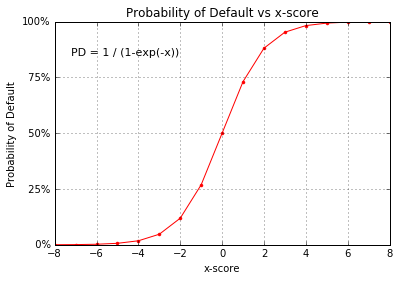

In [7]:
plt.plot(xdf['x'],xdf['pd'],'r-',marker='.')
plt.yticks([0.,.25,.5,.75,1.])
plt.ylabel('Probability of Default')

# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.25)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)

plt.xlabel('x-score')
plt.grid('on')
plt.annotate('PD = 1 / (1-exp(-x))', xy=(0.05, 0.85),\
               xycoords='axes fraction', fontsize=11) # var listing annotation
plt.title('Probability of Default vs x-score')
plt.savefig('PD_vs_xscore'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
mdf=md[['AsOf','IDRSSD','f4']].groupby(['f4','AsOf']).count()
mdf=mdf.unstack(0)
mdf.ix['2007':]

IDRSSD       
f4               0      1
AsOf                     
2007-03-31  7677.0    3.0
2007-06-30  7641.0    5.0
2007-09-30  7588.0    9.0
2007-12-31  7549.0   24.0
2008-03-31  7496.0   44.0
2008-06-30  7458.0   63.0
2008-09-30  7387.0   99.0
2008-12-31  7315.0  117.0
2009-03-31  7260.0  129.0
2009-06-30  7206.0  137.0
2009-09-30  7149.0  124.0
2009-12-31  7095.0  125.0
2010-03-31  7045.0  106.0
2010-06-30  6965.0   86.0
2010-09-30  6909.0   79.0
2010-12-31  6820.0   77.0
2011-03-31  6759.0   64.0
2011-06-30  6709.0   50.0
2011-09-30  6670.0   39.0
2011-12-31  6627.0   36.0
2012-03-31  6620.0   32.0
2012-06-30  6580.0   27.0
2012-09-30  6560.0   25.0
2012-12-31  7051.0   21.0
2013-03-31  6986.0   20.0
2013-06-30  6917.0   19.0
2013-09-30  6869.0   13.0
2013-12-31  6785.0   17.0
2014-03-31  6708.0   12.0
2014-06-30  6649.0    6.0
2014-09-30  6586.0    3.0
2014-12-31  6500.0    NaN

In [9]:
#md09 = md[md['AsOf']>'2008-12-31']
md09 = md[md['AsOf']=='2009-12-31']
md09['f4j'] = md09.apply(lambda x: x['f4']+rd.gauss(0,.05),axis=1)  ## jitter f4 fail flag
len(md09)

7220

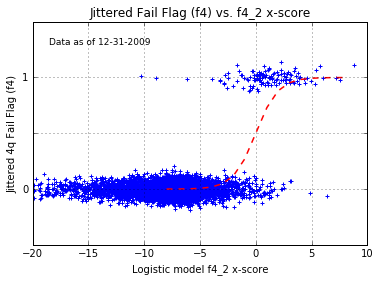

In [10]:
plt.scatter(md09['xf4_2'],md09['f4j'],marker='+',c='b')
plt.plot(xdf['x'],xdf['pd'],'r--',lw=1.5)
plt.xlim([-20,10])
plt.title('Jittered Fail Flag (f4) vs. f4_2 x-score')
plt.ylabel('Jittered 4q Fail Flag (f4)')
plt.yticks([-.5,0,.5,1.,1.5],['','0','','1',''])
plt.xlabel('Logistic model f4_2 x-score')
plt.grid('on')
plt.annotate('Data as of 12-31-2009', xy=(0.05, 0.9),\
               xycoords='axes fraction', fontsize=9) # var listing annotation
plt.savefig('f4_2xscore_vs_jitteredf4'+'.png', dpi=300, bbox_inches='tight')
plt.show()

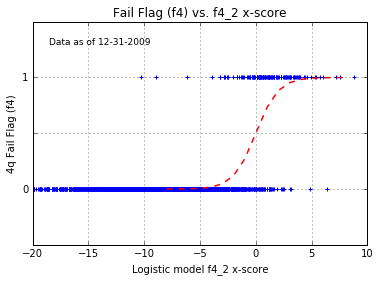

In [11]:
plt.scatter(md09['xf4_2'],md09['f4'],marker='+',c='b')
plt.plot(xdf['x'],xdf['pd'],'r--',lw=1.5)
plt.xlim([-20,10])
plt.title('Fail Flag (f4) vs. f4_2 x-score')
plt.ylabel('4q Fail Flag (f4)')
plt.yticks([-.5,0,.5,1.,1.5],['','0','','1',''])
plt.xlabel('Logistic model f4_2 x-score')
plt.grid('on')
plt.annotate('Data as of 12-31-2009', xy=(0.05, 0.9),\
               xycoords='axes fraction', fontsize=9) # var listing annotation
plt.savefig('f4_2xscore_vs_f4'+'.png', dpi=300, bbox_inches='tight')
plt.show()

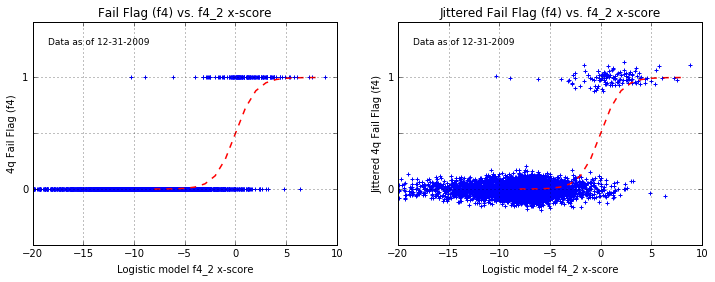

In [13]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

#plt.rcParams.update({'font.size': 4})

plt.subplot(1, 2, 1)
plt.scatter(md09['xf4_2'],md09['f4'],marker='+',c='b')
plt.plot(xdf['x'],xdf['pd'],'r--',lw=1.5)
plt.xlim([-20,10])
plt.title('Fail Flag (f4) vs. f4_2 x-score')
plt.ylabel('4q Fail Flag (f4)')
plt.yticks([-.5,0,.5,1.,1.5],['','0','','1',''])
plt.xlabel('Logistic model f4_2 x-score')
plt.grid('on')
plt.annotate('Data as of 12-31-2009', xy=(0.05, 0.9),\
               xycoords='axes fraction', fontsize=9) # var listing annotation

plt.subplot(1, 2, 2)
plt.scatter(md09['xf4_2'],md09['f4j'],marker='+',c='b')
plt.plot(xdf['x'],xdf['pd'],'r--',lw=1.5)
plt.xlim([-20,10])
plt.title('Jittered Fail Flag (f4) vs. f4_2 x-score')
plt.ylabel('Jittered 4q Fail Flag (f4)')
plt.yticks([-.5,0,.5,1.,1.5],['','0','','1',''])
plt.xlabel('Logistic model f4_2 x-score')
plt.grid('on')
plt.annotate('Data as of 12-31-2009', xy=(0.05, 0.9),\
               xycoords='axes fraction', fontsize=9) # var listing annotation

plt.savefig('Jittered_and_not_f4_2xscore_vs_f4'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
#bin = [-100,-75,-50,-25,-20,-15,-12,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,10,12,15,20]
bin = [-100,-20,-12,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,10,15]
bin2 = [x+.5 for x in bin]
bin2

[-99.5,
 -19.5,
 -11.5,
 -9.5,
 -8.5,
 -7.5,
 -6.5,
 -5.5,
 -4.5,
 -3.5,
 -2.5,
 -1.5,
 -0.5,
 0.5,
 1.5,
 2.5,
 3.5,
 4.5,
 5.5,
 6.5,
 7.5,
 8.5,
 10.5,
 15.5]

In [15]:
## calc bins using all data 2009-2014:

In [16]:
mdf = md[md['AsOf']>'2009-01-01']
len(mdf)

165272

In [17]:
out1 = pd.cut(mdf[mdf['f4']==1].xf4_2, bins = bin)
cnt1 = pd.DataFrame(pd.value_counts(out1))
cnt1.columns=['nbr1']
out0 = pd.cut(mdf[mdf['f4']==0].xf4_2, bins = bin)
cnt0 = pd.DataFrame(pd.value_counts(out0))
cnt0.columns=['nbr0']
cnt = cnt0.merge(cnt1,how='outer',left_index=True,right_index=True)
cnt.reset_index(drop=False,inplace=True)
cnt.head()

index   nbr0  nbr1
0      (-1, 0]    430   182
1    (-10, -9]  17312     1
2  (-100, -20]   3520     0
3   (-12, -10]  17757     3
4     (-2, -1]    854   120

In [18]:
cnt['low'] = cnt.apply(lambda x: x['index'][1:x['index'].index(',')], axis=1)
cnt['low'] = cnt['low'].convert_objects(convert_numeric=True)
cnt.sort_index(by='low',ascending=True,inplace=True)
cnt.reset_index(drop=True,inplace=True)
cnt = cnt[['index','low','nbr0','nbr1']]
cnt2 = cnt.copy()
cnt2.drop('low',axis=1,inplace=True)
cnt2.columns = ['BinRange','f4=0','f4=1']
cnt2all = cnt2.copy()
cnt2

BinRange   f4=0  f4=1
0   (-100, -20]   3520     0
1    (-20, -12]  15503     0
2    (-12, -10]  17757     3
3     (-10, -9]  17312     1
4      (-9, -8]  27441     2
5      (-8, -7]  36068     7
6      (-7, -6]  27710    13
7      (-6, -5]   9556     6
8      (-5, -4]   3771    24
9      (-4, -3]   2163    56
10     (-3, -2]   1500    85
11     (-2, -1]    854   120
12      (-1, 0]    430   182
13       (0, 1]    208   202
14       (1, 2]    127   173
15       (2, 3]     65   137
16       (3, 4]     26   119
17       (4, 5]      9    71
18       (5, 6]      3    30
19       (6, 7]      2     6
20       (7, 8]      0     7
21      (8, 10]      0     2
22     (10, 15]      0     1

In [19]:
out15 = pd.cut(mdf[mdf['f4']==1].xf4_2, bins = bin2)
cnt15 = pd.DataFrame(pd.value_counts(out15))
cnt15.columns=['nbr1']
out05 = pd.cut(mdf[mdf['f4']==0].xf4_2, bins = bin2)
cnt05 = pd.DataFrame(pd.value_counts(out05))
cnt05.columns=['nbr0']
cnt5 = cnt05.merge(cnt15,how='outer',left_index=True,right_index=True)
cnt5.reset_index(drop=False,inplace=True)
cnt5.head()

index   nbr0  nbr1
0     (-0.5, 0.5]    300   192
1    (-1.5, -0.5]    606   154
2   (-11.5, -9.5]  22324     4
3  (-19.5, -11.5]  18330     0
4    (-2.5, -1.5]   1244   102

In [20]:
cnt5['low'] = cnt5.apply(lambda x: x['index'][1:x['index'].index(',')], axis=1)
cnt5['low'] = cnt5['low'].convert_objects(convert_numeric=True)
cnt5.sort_index(by='low',ascending=True,inplace=True)
cnt5.reset_index(drop=True,inplace=True)
cnt5 = cnt5[['index','low','nbr0','nbr1']]
cnt25 = cnt5.copy()
cnt25.drop('low',axis=1,inplace=True)
cnt25.columns = ['BinRange','f4=0','f4=1']
cnt25all = cnt25.copy()
cnt25

BinRange   f4=0  f4=1
0   (-99.5, -19.5]   3824     0
1   (-19.5, -11.5]  18330     0
2    (-11.5, -9.5]  22324     4
3     (-9.5, -8.5]  21976     1
4     (-8.5, -7.5]  32731     5
5     (-7.5, -6.5]  35055     7
6     (-6.5, -5.5]  17153    12
7     (-5.5, -4.5]   5753    15
8     (-4.5, -3.5]   2678    39
9     (-3.5, -2.5]   1738    69
10    (-2.5, -1.5]   1244   102
11    (-1.5, -0.5]    606   154
12     (-0.5, 0.5]    300   192
13      (0.5, 1.5]    153   193
14      (1.5, 2.5]     97   143
15      (2.5, 3.5]     41   140
16      (3.5, 4.5]     12    95
17      (4.5, 5.5]      7    47
18      (5.5, 6.5]      3    17
19      (6.5, 7.5]      0     8
20      (7.5, 8.5]      0     1
21     (8.5, 10.5]      0     3
22    (10.5, 15.5]      0     0

In [21]:
mdf.tail(2)

IDRSSD       AsOf                            Name State   eTotAst  \
405035  4569167 2014-12-31             NEW TRADITIONS BANK    FL  505699.0   
405039  4589857 2014-09-30  INVESCO NATIONAL TRUST COMPANY    GA   39151.0   

         rcTotLn  qnTotLn        rNIM     rPPNR       rROA    ...      f8  \
405035  0.048897      0.0    3.429863  1.871445   0.938726    ...       0   
405039  0.000000      0.0  188.235294  3.837989  18.953723    ...       0   

        mtf2  Intercept          f2_0          f2_1          f4_2  \
405035   NaN        1.0  6.965700e-05  1.170351e-04  3.172648e-04   
405039   NaN        1.0  2.125500e-39  5.977057e-38  9.596074e-34   

                f4_3          f6_4          f6_5      xf4_2  
405035  2.000274e-04  6.249140e-04  8.366936e-04  -8.055456  
405039  2.751094e-45  5.930394e-37  4.611894e-29 -76.026539  

[2 rows x 34 columns]

In [26]:
mdf['AsOf'].min()

Timestamp('2009-03-31 00:00:00')

In [22]:
## data for 2009 only:

In [23]:
md09 = mdf[mdf['AsOf']<'2010-01-01']
len(md09)

29225

In [24]:
out1 = pd.cut(md09[md09['f4']==1].xf4_2, bins = bin)
cnt1 = pd.DataFrame(pd.value_counts(out1))
cnt1.columns=['nbr1']
out0 = pd.cut(md09[md09['f4']==0].xf4_2, bins = bin)
cnt0 = pd.DataFrame(pd.value_counts(out0))
cnt0.columns=['nbr0']
cnt = cnt0.merge(cnt1,how='outer',left_index=True,right_index=True)
cnt.reset_index(drop=False,inplace=True)
cnt.head()

index  nbr0  nbr1
0      (-1, 0]    91    70
1    (-10, -9]  2111     1
2  (-100, -20]   586     0
3   (-12, -10]  2308     3
4     (-2, -1]   176    56

In [25]:
cnt['low'] = cnt.apply(lambda x: x['index'][1:x['index'].index(',')], axis=1)
cnt['low'] = cnt['low'].convert_objects(convert_numeric=True)
cnt.sort_index(by='low',ascending=True,inplace=True)
cnt.reset_index(drop=True,inplace=True)
cnt = cnt[['index','low','nbr0','nbr1']]
cnt2 = cnt.copy()
cnt2.drop('low',axis=1,inplace=True)
cnt2.columns = ['BinRange','f4=0','f4=1']
cnt2_09 = cnt2.copy()
cnt2_09

BinRange  f4=0  f4=1
0   (-100, -20]   586     0
1    (-20, -12]  2342     0
2    (-12, -10]  2308     3
3     (-10, -9]  2111     1
4      (-9, -8]  3384     2
5      (-8, -7]  5175     3
6      (-7, -6]  6525     3
7      (-6, -5]  3503     3
8      (-5, -4]  1396    20
9      (-4, -3]   645    35
10     (-3, -2]   377    59
11     (-2, -1]   176    56
12      (-1, 0]    91    70
13       (0, 1]    49    76
14       (1, 2]    25    61
15       (2, 3]     9    52
16       (3, 4]     3    36
17       (4, 5]     3    17
18       (5, 6]     0    11
19       (6, 7]     2     2
20       (7, 8]     0     4
21      (8, 10]     0     1
22     (10, 15]     0     0

In [27]:
## data for Dec-2009 only:

In [28]:
md09z = mdf[mdf['AsOf']=='2009-12-31']
len(md09z)

7220

In [30]:
out1z = pd.cut(md09z[md09z['f4']==1].xf4_2, bins = bin)
cnt1z = pd.DataFrame(pd.value_counts(out1z))
cnt1z.columns=['nbr1']
out0z = pd.cut(md09z[md09z['f4']==0].xf4_2, bins = bin)
cnt0z = pd.DataFrame(pd.value_counts(out0z))
cnt0z.columns=['nbr0']
cntz = cnt0z.merge(cnt1z,how='outer',left_index=True,right_index=True)
cntz.reset_index(drop=False,inplace=True)
cntz.head()

index  nbr0  nbr1
0      (-1, 0]    32    14
1    (-10, -9]   506     0
2  (-100, -20]   136     0
3   (-12, -10]   563     1
4     (-2, -1]    55     7

In [31]:
cntz['low'] = cntz.apply(lambda x: x['index'][1:x['index'].index(',')], axis=1)
cntz['low'] = cntz['low'].convert_objects(convert_numeric=True)
cntz.sort_index(by='low',ascending=True,inplace=True)
cntz.reset_index(drop=True,inplace=True)
cntz = cntz[['index','low','nbr0','nbr1']]
cnt2z = cntz.copy()
cnt2z.drop('low',axis=1,inplace=True)
cnt2z.columns = ['BinRange','f4=0','f4=1']
cnt2_09z = cnt2z.copy()
cnt2_09z

BinRange  f4=0  f4=1
0   (-100, -20]   136     0
1    (-20, -12]   544     0
2    (-12, -10]   563     1
3     (-10, -9]   506     0
4      (-9, -8]   863     1
5      (-8, -7]  1335     0
6      (-7, -6]  1604     1
7      (-6, -5]   821     0
8      (-5, -4]   340     0
9      (-4, -3]   155     3
10     (-3, -2]   102     7
11     (-2, -1]    55     7
12      (-1, 0]    32    14
13       (0, 1]    18    29
14       (1, 2]    13    21
15       (2, 3]     4    15
16       (3, 4]     2    15
17       (4, 5]     1     4
18       (5, 6]     0     3
19       (6, 7]     1     1
20       (7, 8]     0     2
21      (8, 10]     0     1
22     (10, 15]     0     0